# Molecular filtering(Unwanted substructures)

In [1]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

/home/dbsejrgus226/miniconda3/envs/606server_virtual_env_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#### load data 

egfr_data = pd.read_csv("./data/EGFR_compounds_lipinski.csv",index_col=0,)

# Drop unnecessary information

print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
egfr_data.head()

Dataframe shape: (5431, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,True
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True


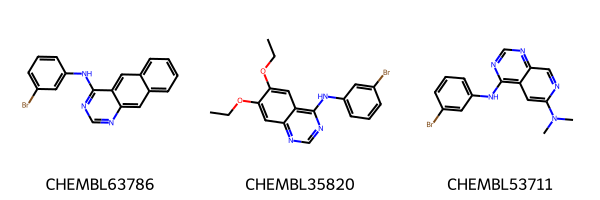

In [16]:
# Add molecule column

PandasTools.AddMoleculeColumnToFrame(egfr_data, smilesCol="smiles")

# Draw first 3 molecules

Chem.Draw.MolsToGridImage(
    list(egfr_data.head(3).ROMol),
    legends=list(egfr_data.head(3).molecule_chembl_id))

In [17]:
#### Filter for PAINS
'''
PAINS are compounds that often occur as hits in HTS even though they actually are false positives. 
PAINS show activity at numerous targets rather than one specific target. 
Such behavior results from unspecific binding or interaction with assay components.
'''
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

# PAINS를 가지고 있으면 selectivity가 없어 아무 protein에 잘 결합할 수 있어 PAINS를 가지는 molecules은 제외 대상

In [18]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]  # keep molecules without PAINS

100%|██████████| 5431/5431 [00:15<00:00, 355.93it/s]


In [19]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(egfr_data)}")
matches

Number of compounds with PAINS: 490
Number of compounds without PAINS: 4941


,chembl_id,rdkit_molecule,pains
0,CHEMBL5220645,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad76c00>,Anil_di_alk_g(9)
1,CHEMBL93032,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad76ab0>,Catechol_a(92)
2,CHEMBL5191510,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad76b20>,Mannich_a(296)
3,CHEMBL4858583,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad76dc0>,Azo_a(324)
4,CHEMBL2029429,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad76810>,Anil_di_alk_a(478)
...,...,...,...
485,CHEMBL145,<rdkit.Chem.rdchem.Mol object at 0x7f6bfaee2a40>,Catechol_a(92)
486,CHEMBL57663,<rdkit.Chem.rdchem.Mol object at 0x7f6bfaee28f0>,Ene_cyano_a(19)
487,CHEMBL294681,<rdkit.Chem.rdchem.Mol object at 0x7f6bfaee3f40>,Ene_cyano_a(19)
488,CHEMBL294213,<rdkit.Chem.rdchem.Mol object at 0x7f6bfaee2960>,Ene_cyano_a(19)


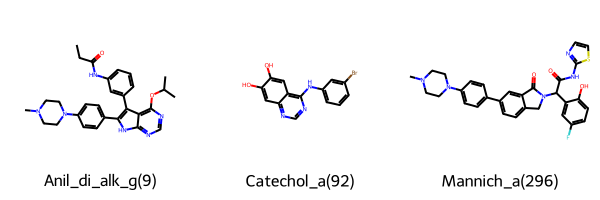

In [20]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

In [27]:
####  Filter and highlight unwanted substructures
'''
Some lists of unwanted substructures, like PAINS, are already implemented in RDKit.
'''
substructures = pd.read_csv("./data/unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
substructures

Number of unwanted substructures in collection: 104


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_65892/3175524315.py:5: SyntaxWarning: invalid escape sequence '\s'
  substructures = pd.read_csv("./data/unwanted_substructures.csv", sep="\s+")


,name,smarts,rdkit_molecule
0,>2EsterGroups,"C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]",<rdkit.Chem.rdchem.Mol object at 0x7f6bfafad310>
1,2-haloPyridine,"n1c([F,Cl,Br,I])cccc1",<rdkit.Chem.rdchem.Mol object at 0x7f6bfafad690>
2,acidHalide,"C(=O)[Cl,Br,I,F]",<rdkit.Chem.rdchem.Mol object at 0x7f6bfafad380>
3,acyclic-C=C-O,C=[C!r]O,<rdkit.Chem.rdchem.Mol object at 0x7f6bfafae3b0>
4,acylCyanide,N#CC(=O),<rdkit.Chem.rdchem.Mol object at 0x7f6bfafad2a0>
...,...,...,...
99,thiol,[SH],<rdkit.Chem.rdchem.Mol object at 0x7f6bfad35700>
100,Three-membered-heterocycle,"*1[O,S,N]*1",<rdkit.Chem.rdchem.Mol object at 0x7f6bfad35690>
101,triflate,OS(=O)(=O)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad35620>
102,triphenyl-methylsilyl,"[SiR0,CR0](c1ccccc1)(c2ccccc2)(c3ccccc3)",<rdkit.Chem.rdchem.Mol object at 0x7f6bfad355b0>


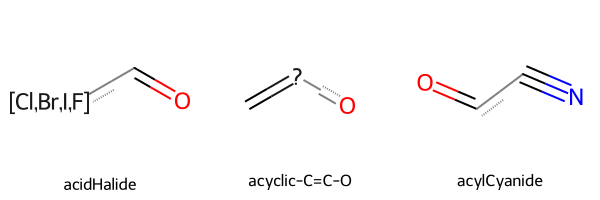

In [31]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5])

In [32]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]

100%|██████████| 4941/4941 [00:33<00:00, 149.21it/s]


In [33]:
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(egfr_data)}")
matches

Number of found unwanted substructure: 3826
Number of compounds without unwanted substructure: 2397


,chembl_id,rdkit_molecule,substructure,substructure_name
0,CHEMBL63786,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad53920>,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad36030>,Polycyclic-aromatic-hydrocarbon
1,CHEMBL1243316,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad53b50>,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad37f40>,Aliphatic-long-chain
2,CHEMBL1243316,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad53b50>,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad36960>,Michael-acceptor
3,CHEMBL1243316,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad53b50>,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad35540>,triple-bond
4,CHEMBL3613702,<rdkit.Chem.rdchem.Mol object at 0x7f6bfafafed0>,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad37060>,halogenated-ring
...,...,...,...,...
3821,CHEMBL308133,<rdkit.Chem.rdchem.Mol object at 0x7f6bfa032ab0>,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad36960>,Michael-acceptor
3822,CHEMBL308133,<rdkit.Chem.rdchem.Mol object at 0x7f6bfa032ab0>,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad36810>,Michael-acceptor
3823,CHEMBL75718,<rdkit.Chem.rdchem.Mol object at 0x7f6bfa032c00>,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad37920>,conjugated-nitrile-group
3824,CHEMBL66879,<rdkit.Chem.rdchem.Mol object at 0x7f6bfa032b20>,<rdkit.Chem.rdchem.Mol object at 0x7f6bfad36960>,Michael-acceptor


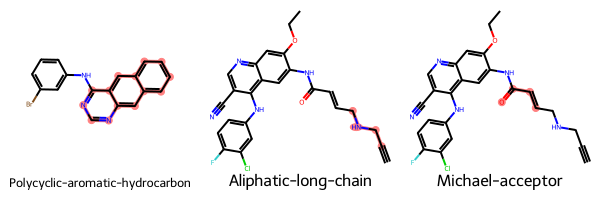

In [34]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name))

In [35]:
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
Michael-acceptor               1328
Aliphatic-long-chain            546
Oxygen-nitrogen-single-bond     446
triple-bond                     293
nitro-group                     194
imine                           187
Thiocarbonyl-group              124
aniline                          81
hydroxamic-acid                  79
halogenated-ring                 75
dtype: int64